# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

Google Colab notebooks come with most of the packages we need, but we need to upgrade pandas and install accelerate.

Then we import the necessary CerberusTS modules.

In [1]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Print the number of available CUDA devices
    print(f"Number of CUDA devices available: {torch.cuda.device_count()}")

    # Print each CUDA device
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

Number of CUDA devices available: 1
CUDA Device 0: NVIDIA GeForce GTX 1650 with Max-Q Design


In [2]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True
CerberusConfig.processor_type = 'flatten'
CerberusConfig.foresight_residual = False

c:\Users\johnm\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import Foresight, train_foresight
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator

import pandas as pd

Here we have the ability to do some custom configuration:

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [4]:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [5]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use.

In [6]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 64)

# Prepare the data
preparer.prepare_data()

In [7]:
iterator = iter(preparer.dataloaders)
batch = next(iterator)
batch[0].device

device(type='cuda', index=0)

## Foresight Training

First, we can optionally train Foresight to aid CerberusTS:

In [8]:
foresight = Foresight(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=512,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [512, 256],
                 dropout_rate = 0.0,
                 eventualities = 10,
                 expander_sizes = [256, 512],
                 out_channels = 128,
                 kernel_size = 3)

In [9]:
foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.0029066869797119603
Epoch [2/100], Loss: 0.0016147611876979422
Epoch [3/100], Loss: 0.001025601740392407
Epoch [4/100], Loss: 0.0006030228869697918
Epoch [5/100], Loss: 0.00033960061760756157
Epoch [6/100], Loss: 0.0002078967291758375
Epoch [7/100], Loss: 0.0001511395663276282
Epoch [8/100], Loss: 0.00012471607405809126
Epoch [9/100], Loss: 0.00010287580794675986
Epoch [10/100], Loss: 9.08637706475993e-05
Epoch [11/100], Loss: 9.271424238749679e-05
Epoch [12/100], Loss: 8.511906122212661e-05
Epoch [13/100], Loss: 8.316074365775247e-05
Epoch [14/100], Loss: 8.426131106202324e-05
Epoch [15/100], Loss: 0.00010207829289432145
Epoch [16/100], Loss: 8.089400570041474e-05
Epoch [17/100], Loss: 5.85473174399517e-05
Epoch [18/100], Loss: 8.163118979665072e-05
Epoch [19/100], Loss: 0.0004319543048087433
Epoch [20/100], Loss: 0.00020620168982476842
Epoch [21/100], Loss: 5.5861087743666756e-05
Epoch [22/100], Loss: 4.3868825149041015e-05
Epoch [23/100], Loss: 3.5859744434165

## CerberusTS Training (No Foresight)

In [10]:
cerberus_noforesight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=1024  ,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [1024, 512, 256, 128],
                 dropout_rate = 0.0,
                 out_channels = 128,
                 kernel_size = 3)
                 

In [11]:
cerberus_noforesight = train_cerberus(cerberus_noforesight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.0004977951332675323
Epoch [2/100], Loss: 0.00035883744727796356
Epoch [3/100], Loss: 0.00033717371934181313
Epoch [4/100], Loss: 0.0003103922751561825
Epoch [5/100], Loss: 0.00029072150523505044
Epoch [6/100], Loss: 0.00027475518224866517
Epoch [7/100], Loss: 0.0002578020832905272
Epoch [8/100], Loss: 0.00024606852328494793
Epoch [9/100], Loss: 0.00023534137080758274
Epoch [10/100], Loss: 0.0002285942858153472
Epoch [11/100], Loss: 0.00021592590154688687
Epoch [12/100], Loss: 0.00020967165933186992
Epoch [13/100], Loss: 0.00020419415320826177
Epoch [14/100], Loss: 0.00019323116641851683
Epoch [15/100], Loss: 0.00018979676204793804
Epoch [16/100], Loss: 0.00017721645952278254
Epoch [17/100], Loss: 0.00017222220144314936
Epoch [18/100], Loss: 0.00016198165220254586
Epoch [19/100], Loss: 0.00015538374470478404
Epoch [20/100], Loss: 0.000151925490279801
Epoch [21/100], Loss: 0.00014334812480658768
Epoch [22/100], Loss: 0.00013424621620840323
Epoch [23/100], Loss: 0.0

## CerberusTS Training (With Foresight)
With the Foresight model trained (and weights frozen), we can pass this into a Cerberus model and train the remaining weights to generate predictions.

In [12]:
cerberus_foresight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=1024,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [1024, 512, 256, 128],
                 dropout_rate = 0.0,
                 foresight = foresight,
                 eventualities = 10,
                 out_channels = 128,
                 kernel_size = 3)

In [13]:
cerberus_foresight = train_cerberus(cerberus_foresight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.000500986880151192
Epoch [2/100], Loss: 0.000288764972941944
Epoch [3/100], Loss: 0.00022138845832061065
Epoch [4/100], Loss: 0.00017211142410513032
Epoch [5/100], Loss: 0.00014485410460569976
Epoch [6/100], Loss: 0.00012528798130767482
Epoch [7/100], Loss: 0.00010810765877268247
Epoch [8/100], Loss: 9.467456637273213e-05
Epoch [9/100], Loss: 8.507207736509448e-05
Epoch [10/100], Loss: 7.5997099991774e-05
Epoch [11/100], Loss: 7.243538248976998e-05
Epoch [12/100], Loss: 6.59713098338951e-05
Epoch [13/100], Loss: 6.064083508783788e-05
Epoch [14/100], Loss: 5.4619393296842535e-05
Epoch [15/100], Loss: 5.091134944130829e-05
Epoch [16/100], Loss: 4.730912260942722e-05
Epoch [17/100], Loss: 4.731976592904158e-05
Epoch [18/100], Loss: 4.5361770872069826e-05
Epoch [19/100], Loss: 4.410763927407157e-05
Epoch [20/100], Loss: 4.0934389926115286e-05
Epoch [21/100], Loss: 3.938244345698159e-05
Epoch [22/100], Loss: 3.903472140072395e-05
Epoch [23/100], Loss: 3.65392677431315

## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results.

### Normalized Response Review

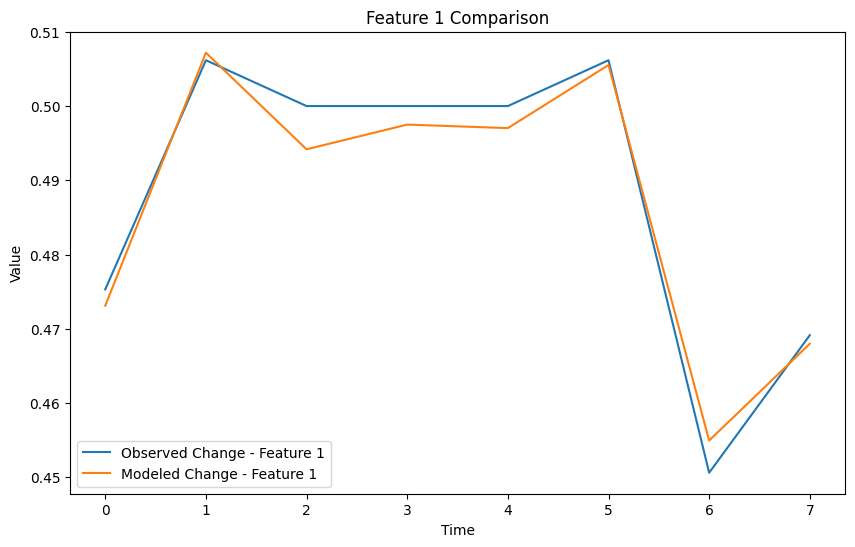

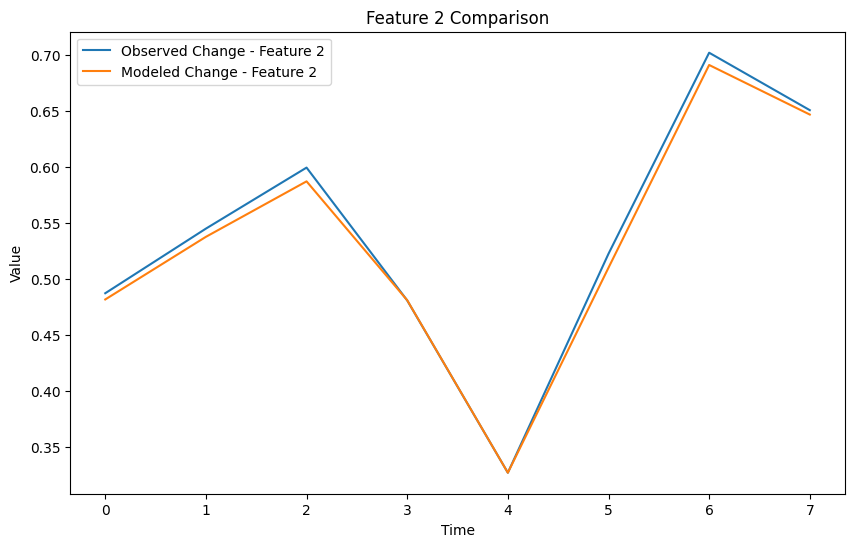

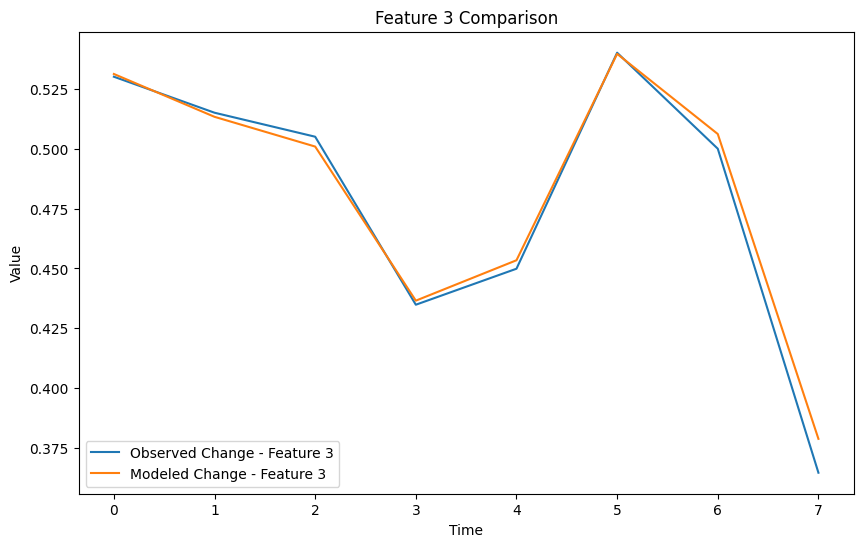

In [29]:
# Intialize Response Generator
generator = ResponseGenerator(cerberus_foresight, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 123
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

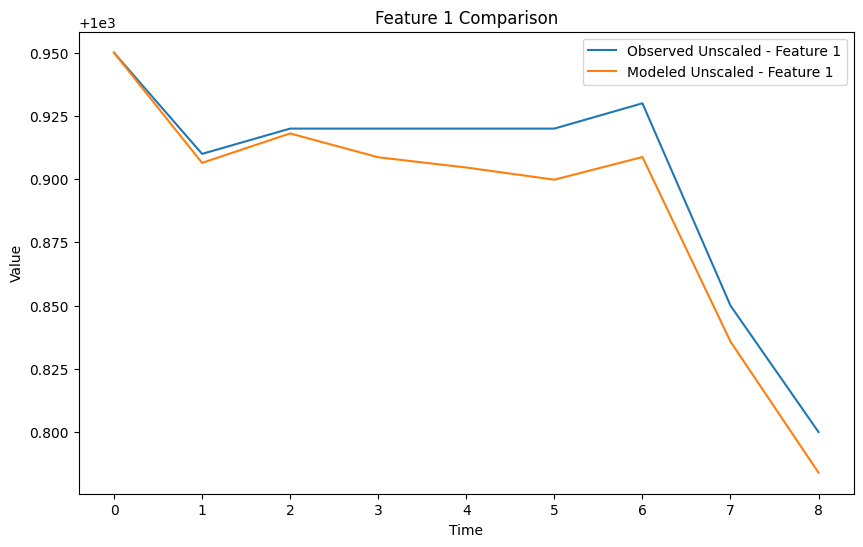

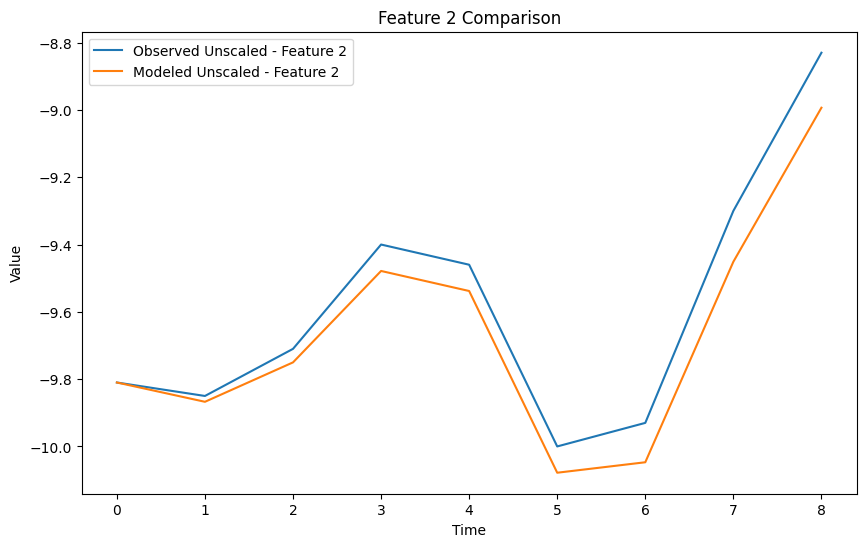

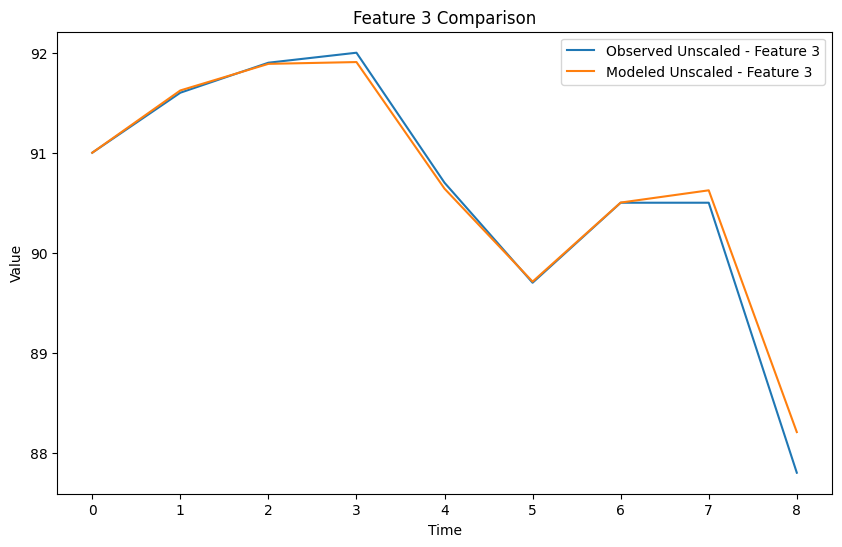

In [30]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)